# Определение стоимости автомобилей

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, OrdinalEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
auto_df = pd.read_csv('/datasets/autos.csv')
display(auto_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


None

In [3]:
auto_df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
auto_df.shape

(354369, 16)

In [5]:
auto_df.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
NotRepaired          0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

In [6]:
auto_df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

В столбцах VehicleType, Gearbox, FuelType и NotRepaired есть пропусками. Расммотрим данные в каждом столбце.

In [7]:
print("Количество марок автомобилей:", len(auto_df["Brand"].unique()))
print("Количество моделей автомобилей:", len(auto_df["Model"].unique()))
print("Кузов автомобиля:", len(auto_df["VehicleType"].unique()))
print("Средний пробег: {:.0f}".format(auto_df["Kilometer"].mean()))

Количество марок автомобилей: 40
Количество моделей автомобилей: 251
Кузов автомобиля: 9
Средний пробег: 128211


In [8]:
print(auto_df['RegistrationYear'].unique())

[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290 2500 1930 1001 9450 1944 1943 1934 1938 1688 2800
 1253 1928 1919 5555 5600 1600 2222 1039 9996 1300 8455 1931 1915 4500
 1920 1602 7800 9229 1947 1927 7100 8200 1946 7500 3500]


In [9]:
print(auto_df['RegistrationMonth'].unique())

[ 0  5  8  6  7 10 12 11  2  3  1  4  9]


In [10]:
print(auto_df['Power'].unique())

[    0   190   163    75    69   102   109    50   125   101   105   140
   115   131    60   136   160   231    90   118   193    99   113   218
   122   129    70   306    95    61   177    80   170    55   143    64
   286   232   150   156    82   155    54   185    87   180    86    84
   224   235   200   178   265    77   110   144   120   116   184   126
   204    88   194   305   197   179   250    45   313    41   165    98
   130   114   211    56   201   213    58   107    83   174   100   220
    85    73   192    68    66   299    74    52   147    65   310    71
    97   239   203     5   300   103   258   320    63    81   148    44
   145   230   280   260   104   188   333   186   117   141    59   132
   234   158    39    92    51   135    53   209    43   146    67   106
   166   276   344    72   249   237   245   111   326   279    23   138
   175    96   226    26    37   301   334   128   133   124    33   219
   241   167    94   182   196   238  1398   228   

Значимые признаки:

Power — мощность (л.с.); показатель напрямую влияет на цену авто

VehicleType — тип автомобильного кузова; чем больше функциональных возможностей у авто, тем выше цена

Gearbox — тип коробки передач; при наличии автомата стоимость авто растет

Model — модель автомобиля; как и марка авто влияет на цену

Kilometer — пробег (км); чем больше пробег у авто,тем меньше ее цена при прочих равных

FuelType — тип топлива; показатель определяет конфигурацию двигателя

Brand — марка автомобиля; напрямую влияет на цену

NotRepaired — была машина в ремонте или нет; через амортизацию влияет на цену

RegistrationYear — год регистрации автомобиля; чем старше авто, тем ниже стоимость при прочих равных



Целевой признак - Price (цена)

Создадим новый датафрейм с необходиммыми столбцами для дальнейшей работы

In [11]:
new_auto_df = auto_df[['VehicleType', 
                         'Gearbox', 
                         'Power',
                         'Kilometer',
                         'FuelType',
                         'Brand',
                         'NotRepaired',
                         'RegistrationYear',
                         'Model',
                         'Price']]

In [12]:
new_auto_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
VehicleType         316879 non-null object
Gearbox             334536 non-null object
Power               354369 non-null int64
Kilometer           354369 non-null int64
FuelType            321474 non-null object
Brand               354369 non-null object
NotRepaired         283215 non-null object
RegistrationYear    354369 non-null int64
Model               334664 non-null object
Price               354369 non-null int64
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [13]:
new_auto_df

,VehicleType,Gearbox,Power,Kilometer,FuelType,Brand,NotRepaired,RegistrationYear,Model,Price
0,NaN,manual,0,150000,petrol,volkswagen,NaN,1993,golf,480
1,coupe,manual,190,125000,gasoline,audi,yes,2011,NaN,18300
2,suv,auto,163,125000,gasoline,jeep,NaN,2004,grand,9800
3,small,manual,75,150000,petrol,volkswagen,no,2001,golf,1500
4,small,manual,69,90000,gasoline,skoda,no,2008,fabia,3600
...,...,...,...,...,...,...,...,...,...,...
354364,NaN,manual,0,150000,petrol,mitsubishi,yes,2005,colt,0
354365,NaN,NaN,0,20000,NaN,sonstige_autos,NaN,2005,NaN,2200
354366,convertible,auto,101,125000,petrol,smart,no,2000,fortwo,1199
354367,bus,manual,102,150000,gasoline,volkswagen,no,1996,transporter,9200


In [14]:
new_auto_df['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

В данных достаточно много NaN, нулей и просто некорректных значений.

Столбцы, требующие обработки:

NotRepaired. Для всех пропусков установим значение 'yes'.

RegistrationYear. Приведем к реальным значениям.

Model. Для всех пропусков установим значение 'unknown'.

VehicleType. Будем ориентироваться на столбец Brand при восстановлении пропущенных значений.

Gearbox. Для всех пропусков установим значение 'manual'.

Power. Приведем к реальным значениям.

FuelType. Будем ориентироваться на столбец Brand при восстановлении пропущенных значений.



Рассмотрим данные по целевому признаку Price

In [15]:
new_auto_df['Price'].value_counts()

0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
13440        1
1414         1
8069         1
10370        1
384          1
Name: Price, Length: 3731, dtype: int64

нулей быть не должно, избавимся от них

In [16]:
new_auto_df = new_auto_df.query('Price > 0')

count    343597.000000
mean       4555.121974
std        4515.058553
min           1.000000
25%        1200.000000
50%        2890.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

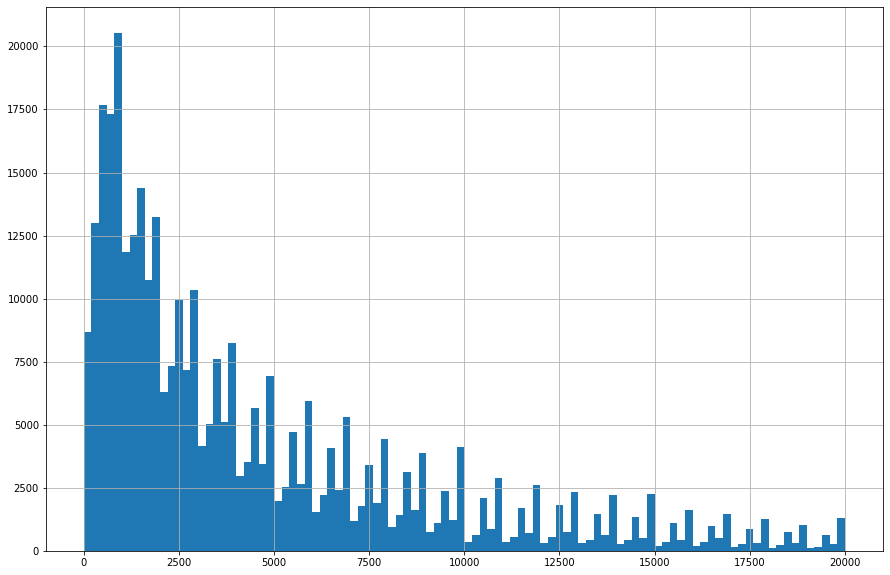

In [17]:
new_auto_df['Price'].hist(bins = 100, figsize = (15, 10))
new_auto_df['Price'].describe()

Выделим квантили 10% и 90%

In [18]:
new_auto_df['Price'].quantile([.1, 0.9])

0.1      590.0
0.9    11500.0
Name: Price, dtype: float64

In [19]:
new_auto_df = new_auto_df.query('590 <= Price <= 11500')

In [20]:
new_auto_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275222 entries, 2 to 354368
Data columns (total 10 columns):
VehicleType         250663 non-null object
Gearbox             263098 non-null object
Power               275222 non-null int64
Kilometer           275222 non-null int64
FuelType            254219 non-null object
Brand               275222 non-null object
NotRepaired         225684 non-null object
RegistrationYear    275222 non-null int64
Model               262333 non-null object
Price               275222 non-null int64
dtypes: int64(4), object(6)
memory usage: 23.1+ MB


In [21]:
new_auto_df['Price'].describe()

count    275222.000000
mean       3774.329556
std        2843.765198
min         590.000000
25%        1450.000000
50%        2899.000000
75%        5500.000000
max       11500.000000
Name: Price, dtype: float64

Рассмаотрим столбец RegistrationYear

count    275222.000000
mean       2003.686838
std          63.744556
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

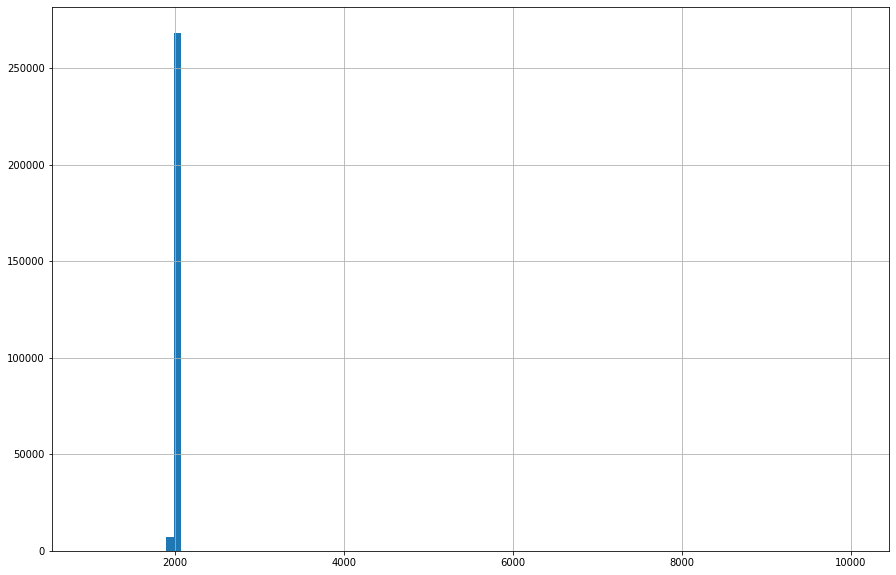

In [22]:
new_auto_df['RegistrationYear'].hist(bins = 100, figsize = (15, 10))
new_auto_df['RegistrationYear'].describe()

In [23]:
new_auto_df['RegistrationYear'].value_counts()

2005    19877
2000    18819
2003    18722
2004    18548
1999    18334
        ...  
1945        1
1944        1
1936        1
1935        1
4100        1
Name: RegistrationYear, Length: 121, dtype: int64

In [24]:
new_auto_df['RegistrationYear'].unique()

array([2004, 2001, 2008, 1995, 1998, 2005, 2007, 2009, 2002, 2018, 2017,
       1981, 2003, 2016, 1991, 1984, 1999, 2006, 2010, 2000, 1992, 1993,
       1997, 2013, 1994, 1996, 1990, 2012, 1989, 2011, 1985, 1982, 2014,
       1976, 1973, 2015, 1971, 1987, 1983, 1988, 1980, 1970, 1986, 1945,
       1965, 1925, 1979, 1974, 1955, 1978, 1972, 1968, 1977, 1966, 1910,
       1975, 1961, 1963, 1969, 1964, 1958, 1967, 3200, 1960, 1941, 9999,
       8888, 1500, 4100, 1957, 2066, 2019, 1937, 1951, 1959, 1954, 1234,
       5300, 1962, 9000, 2900, 6000, 1953, 5911, 1400, 5000, 1000, 1952,
       8500, 1950, 3700, 1942, 7000, 1956, 1935, 1923, 2290, 1930, 1001,
       9450, 1944, 1929, 2500, 1938, 1934, 1943, 1928, 5555, 1600, 1800,
       1932, 1039, 3000, 2800, 1931, 1948, 4500, 7800, 1936, 7100, 1946])

В данном столбце присутствуют выбросы. Уберем хвост.

In [25]:
date = pd.to_datetime(auto_df['DateCrawled'])

In [26]:
date.max()

Timestamp('2016-04-07 14:36:58')

Рассмотрим левую часть гистограммы

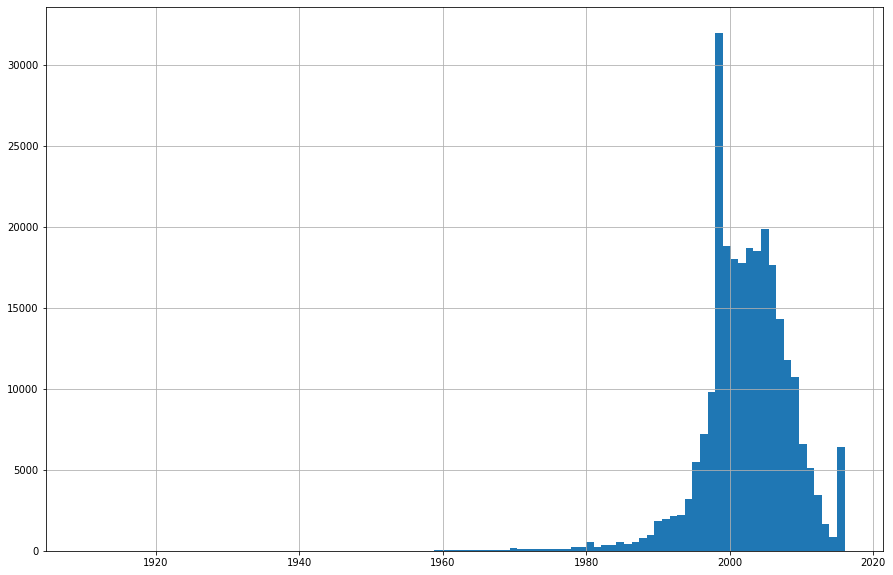

In [27]:
new_auto_df = new_auto_df.query('1899 < RegistrationYear < 2017')
new_auto_df['RegistrationYear'].hist(bins = 100, figsize = (15, 10))

Возьмем срез по левой части не ранее 1980

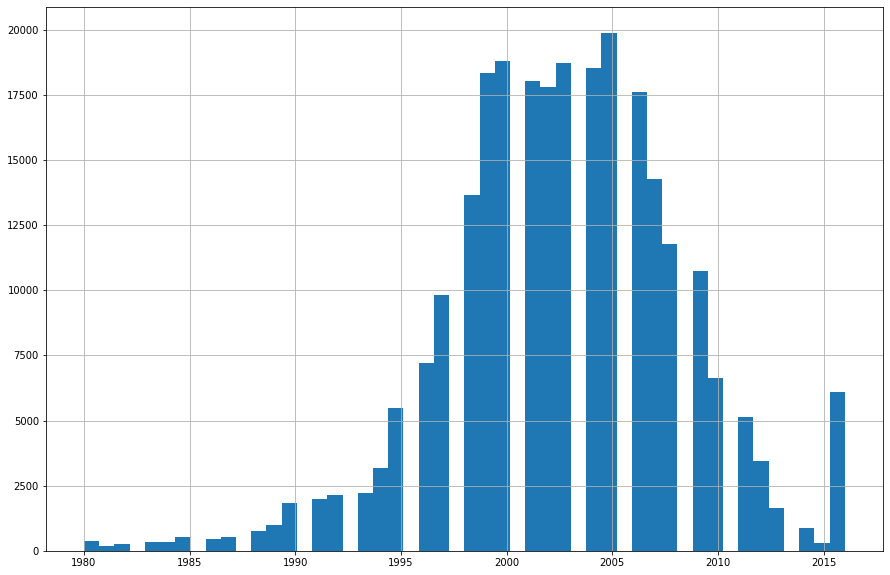

In [28]:
new_auto_df = new_auto_df.query('1979 < RegistrationYear < 2017')
new_auto_df['RegistrationYear'].hist(bins = 50, figsize = (15, 10))

Заменим значения NaN в столбцах Gearbox, NotRepaired и Model.

In [29]:
new_auto_df.fillna({'Gearbox':'manual', 
                           'NotRepaired':'yes',
                           'Model':'unknown'},
                          inplace = True)
new_auto_df.isna().mean()

VehicleType         0.047323
Gearbox             0.000000
Power               0.000000
Kilometer           0.000000
FuelType            0.061600
Brand               0.000000
NotRepaired         0.000000
RegistrationYear    0.000000
Model               0.000000
Price               0.000000
dtype: float64

Исследуем количество пропусков в столбце VehicleType

In [30]:
display(new_auto_df['VehicleType'].value_counts())
new_auto_df['VehicleType'].isna().sum()

sedan          73148
small          62937
wagon          52197
bus            24199
convertible    15261
coupe          11028
suv             7464
other           2389
Name: VehicleType, dtype: int64

12350

Заменим значения NaN в соответствии с популярным типом кузова для каждого бренда.

In [31]:
vehicle_df_table = new_auto_df.pivot_table(index = ['VehicleType'], 
                                                          columns = ['Brand'],
                                                          values = ['Price'],
                                                          aggfunc = ['count'])
display(vehicle_df_table)
new_auto_df[new_auto_df['Brand'] == 'alfa_romeo']['VehicleType'].value_counts()

count                                                     \
                 Price                                                      
Brand       alfa_romeo    audi      bmw chevrolet chrysler citroen  dacia   
VehicleType                                                                 
bus                NaN    10.0      5.0     116.0    351.0  1158.0   35.0   
convertible      134.0  1034.0   2326.0       9.0    200.0    99.0    NaN   
coupe            194.0   785.0   2648.0      48.0     34.0   125.0    NaN   
other              7.0    87.0    173.0      26.0      6.0    90.0    6.0   
sedan            749.0  8567.0  13995.0     185.0    216.0   570.0   98.0   
small            203.0  1038.0    330.0     566.0     10.0  1354.0  218.0   
suv                NaN    17.0    451.0     259.0     15.0    14.0  164.0   
wagon            397.0  8353.0   6210.0      94.0    213.0   506.0  246.0   

                                     ...                          \
                                     ...                           
Brand       daewoo daihatsu    fiat  ...    seat   skoda   smart   
VehicleType                          ...                           
bus           23.0     29.0   728.0  ...   550.0   208.0     1.0   
convertible    1.0     17.0   381.0  ...     NaN     2.0  1093.0   
coupe          2.0      NaN   138.0  ...    59.0     3.0   330.0   
other          5.0      6.0   148.0  ...    45.0    20.0     8.0   
sedan         79.0     38.0   740.0  ...  1397.0   779.0    27.0   
small        204.0    374.0  4082.0  ...  2649.0  1029.0  3141.0   
suv            1.0     44.0    18.0  ...     3.0    46.0     NaN   
wagon         32.0     16.0   319.0  ...   275.0  2215.0     8.0   

                                                                             
                                                                             
Brand       sonstige_autos subaru suzuki  toyota trabant volkswagen   volvo  
VehicleType                                                                  
bus                  160.0   15.0   25.0   400.0     NaN     7546.0     NaN  
convertible          143.0    1.0   33.0    61.0    24.0     2265.0    48.0  
coupe                 68.0    3.0    1.0   186.0     2.0      955.0    51.0  
other                144.0    5.0   11.0    15.0     4.0      585.0     2.0  
sedan                241.0  123.0  131.0   819.0   114.0    16199.0   512.0  
small                155.0   76.0  819.0  1512.0    35.0    14459.0     6.0  
suv                  240.0   50.0  665.0   349.0     NaN      570.0   111.0  
wagon                 99.0  232.0   74.0   495.0    47.0    10681.0  1596.0  

[8 rows x 40 columns]

sedan          749
wagon          397
small          203
coupe          194
convertible    134
other            7
Name: VehicleType, dtype: int64

In [32]:
vehicle_df_table = vehicle_df_table['count']['Price']
vehicle_df_table

Brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,seat,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo
VehicleType,,,,,,,,,,,,,,,,,,,,,
bus,NaN,10.0,5.0,116.0,351.0,1158.0,35.0,23.0,29.0,728.0,...,550.0,208.0,1.0,160.0,15.0,25.0,400.0,NaN,7546.0,NaN
convertible,134.0,1034.0,2326.0,9.0,200.0,99.0,NaN,1.0,17.0,381.0,...,NaN,2.0,1093.0,143.0,1.0,33.0,61.0,24.0,2265.0,48.0
coupe,194.0,785.0,2648.0,48.0,34.0,125.0,NaN,2.0,NaN,138.0,...,59.0,3.0,330.0,68.0,3.0,1.0,186.0,2.0,955.0,51.0
other,7.0,87.0,173.0,26.0,6.0,90.0,6.0,5.0,6.0,148.0,...,45.0,20.0,8.0,144.0,5.0,11.0,15.0,4.0,585.0,2.0
sedan,749.0,8567.0,13995.0,185.0,216.0,570.0,98.0,79.0,38.0,740.0,...,1397.0,779.0,27.0,241.0,123.0,131.0,819.0,114.0,16199.0,512.0
small,203.0,1038.0,330.0,566.0,10.0,1354.0,218.0,204.0,374.0,4082.0,...,2649.0,1029.0,3141.0,155.0,76.0,819.0,1512.0,35.0,14459.0,6.0
suv,NaN,17.0,451.0,259.0,15.0,14.0,164.0,1.0,44.0,18.0,...,3.0,46.0,NaN,240.0,50.0,665.0,349.0,NaN,570.0,111.0
wagon,397.0,8353.0,6210.0,94.0,213.0,506.0,246.0,32.0,16.0,319.0,...,275.0,2215.0,8.0,99.0,232.0,74.0,495.0,47.0,10681.0,1596.0


In [33]:
new_auto_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260973 entries, 2 to 354368
Data columns (total 10 columns):
VehicleType         248623 non-null object
Gearbox             260973 non-null object
Power               260973 non-null int64
Kilometer           260973 non-null int64
FuelType            244897 non-null object
Brand               260973 non-null object
NotRepaired         260973 non-null object
RegistrationYear    260973 non-null int64
Model               260973 non-null object
Price               260973 non-null int64
dtypes: int64(4), object(6)
memory usage: 21.9+ MB


Заполним столбец Brand, Model и  пропуски по столбцу VehicleType.

In [34]:
new_auto_df.fillna({'VehicleType':0}, inplace = True)

In [35]:
def fillna_brand(row, row_number, vehicle_df_table):
    brand = row[5]
    fill_value = row[row_number]
    if row[row_number] == 0:
        fill_value = vehicle_df_table[brand].idxmax()
    return fill_value

In [36]:
new_auto_df['VehicleType'] = new_auto_df.apply(
                                fillna_brand, 
                                args = [0, vehicle_df_table],
                                axis = 1)

In [37]:
display(new_auto_df['VehicleType'].isna().sum())
new_auto_df['VehicleType'].value_counts()

0

sedan          80165
small          67926
wagon          52427
bus            24249
convertible    15261
coupe          11046
suv             7510
other           2389
Name: VehicleType, dtype: int64

Перейдем к заполнению пропусков в столбце FuelType

In [38]:
new_auto_df['FuelType'].value_counts()

petrol      163663
gasoline     75919
lpg           4546
cng            491
hybrid         124
other           90
electric        64
Name: FuelType, dtype: int64

In [39]:
fuel_df_table = new_auto_df.pivot_table(index = ['FuelType'], 
                                                          columns = ['Brand'],
                                                          values = ['Price'],
                                                          aggfunc = ['count'])
fuel_df_table = fuel_df_table['count']['Price']
display(fuel_df_table)

Brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,seat,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo
FuelType,,,,,,,,,,,,,,,,,,,,,
cng,NaN,1.0,7.0,4.0,NaN,7.0,2.0,NaN,NaN,63.0,...,NaN,6.0,2.0,7.0,2.0,NaN,NaN,NaN,164.0,20.0
electric,NaN,2.0,3.0,NaN,NaN,NaN,NaN,NaN,1.0,3.0,...,NaN,NaN,3.0,17.0,NaN,NaN,NaN,NaN,1.0,NaN
gasoline,520.0,8858.0,8045.0,153.0,322.0,1377.0,164.0,1.0,4.0,1283.0,...,1393.0,1470.0,833.0,358.0,22.0,192.0,843.0,1.0,20372.0,762.0
hybrid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,1.0,NaN,1.0,2.0,NaN,NaN,61.0,NaN,4.0,NaN
lpg,30.0,405.0,695.0,161.0,80.0,62.0,49.0,22.0,5.0,61.0,...,56.0,48.0,3.0,80.0,27.0,16.0,19.0,NaN,460.0,93.0
other,NaN,NaN,5.0,NaN,NaN,2.0,NaN,NaN,NaN,2.0,...,NaN,NaN,1.0,9.0,NaN,1.0,NaN,22.0,13.0,2.0
petrol,1117.0,10301.0,16761.0,956.0,626.0,2436.0,532.0,317.0,513.0,5069.0,...,3513.0,2707.0,3734.0,732.0,437.0,1530.0,2885.0,167.0,31865.0,1401.0


In [40]:
new_auto_df.fillna({'FuelType':0}, inplace = True)

In [41]:
new_auto_df['FuelType'] = new_auto_df.apply(
                                fillna_brand, 
                                args = [4, vehicle_df_table],
                                axis = 1)

In [42]:
display(new_auto_df['FuelType'].isna().sum())
new_auto_df['FuelType'].value_counts()

0

petrol      163663
gasoline     75919
sedan         8919
small         6622
lpg           4546
cng            491
wagon          386
hybrid         124
other           90
bus             67
electric        64
suv             62
coupe           20
Name: FuelType, dtype: int64

In [43]:
new_auto_df.isna().mean()

VehicleType         0.0
Gearbox             0.0
Power               0.0
Kilometer           0.0
FuelType            0.0
Brand               0.0
NotRepaired         0.0
RegistrationYear    0.0
Model               0.0
Price               0.0
dtype: float64

C пропусками разобрались, перейдем к столбцу Power

count    260973.000000
mean        110.479302
std         185.688773
min           0.000000
25%          75.000000
50%         105.000000
75%         140.000000
max       20000.000000
Name: Power, dtype: float64

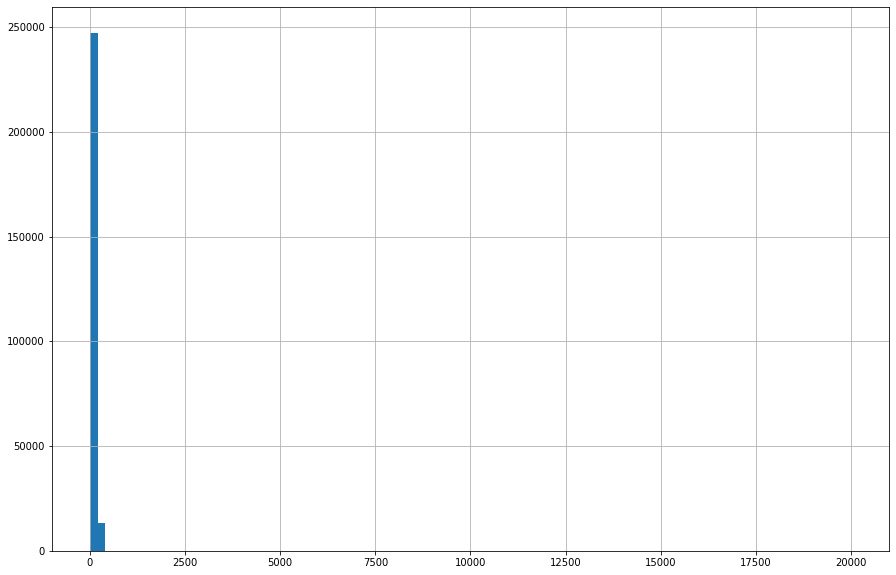

In [44]:
new_auto_df['Power'].hist(bins = 100, figsize = (15, 10))
new_auto_df['Power'].describe()

Разброс весьбма сильный, ликвидируем значения , которые больше 1000 л.с.

count    260759.000000
mean        107.145429
std          57.336145
min           0.000000
25%          75.000000
50%         105.000000
75%         140.000000
max        1000.000000
Name: Power, dtype: float64

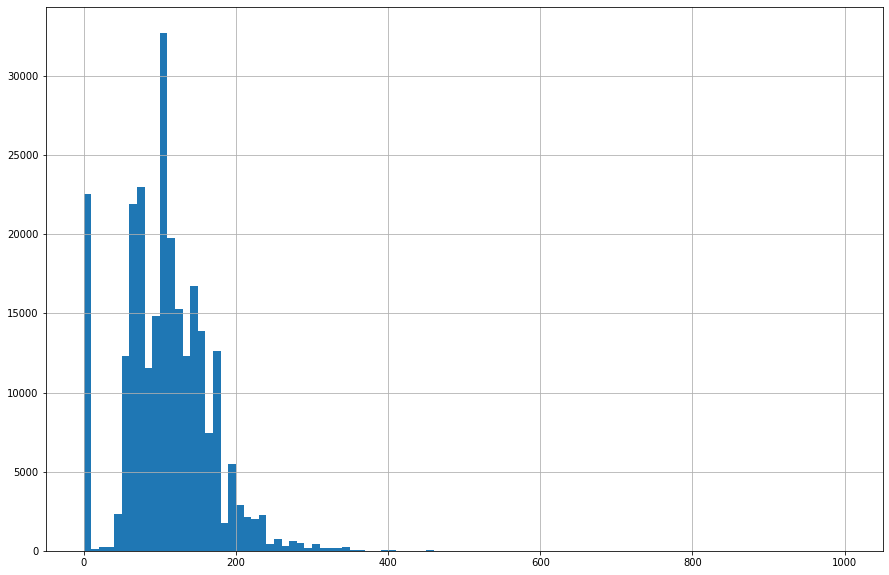

In [45]:
new_auto_df = new_auto_df.query('Power < 1001')
new_auto_df['Power'].hist(bins = 100, figsize = (15, 10))
new_auto_df['Power'].describe()

Судя по описнаию данных в столбце и гистрограмме есть машину, у которых количество л.с. = 0. Удалим эти строки, а с правой стороны ограничим 350 л.с.

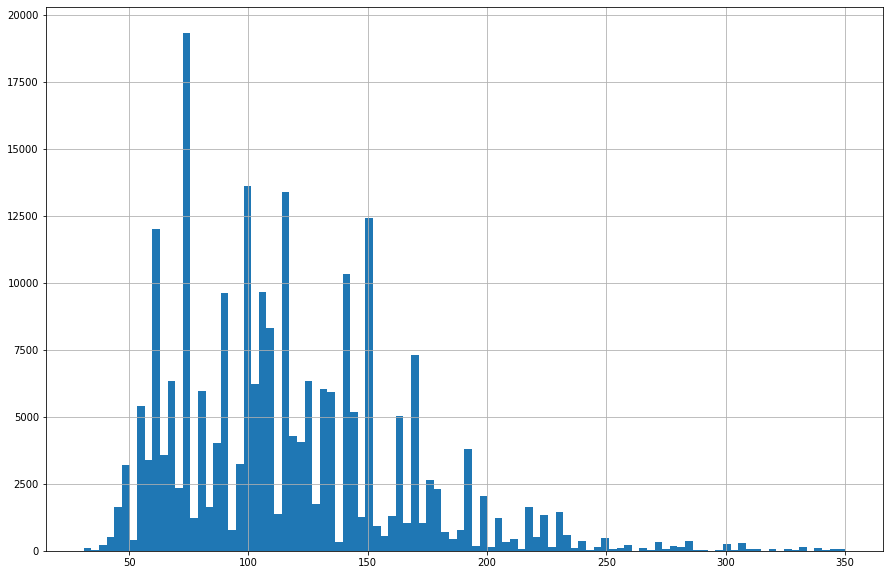

In [46]:
fixed_auto_df = new_auto_df.query('30 < Power < 351')
fixed_auto_df['Power'].hist(bins = 100, figsize = (15, 10))

In [47]:
fixed_auto_df['Power'].describe()

count    237573.000000
mean        117.001111
std          47.216719
min          31.000000
25%          77.000000
50%         109.000000
75%         143.000000
max         350.000000
Name: Power, dtype: float64

In [48]:
fixed_auto_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237573 entries, 2 to 354368
Data columns (total 10 columns):
VehicleType         237573 non-null object
Gearbox             237573 non-null object
Power               237573 non-null int64
Kilometer           237573 non-null int64
FuelType            237573 non-null object
Brand               237573 non-null object
NotRepaired         237573 non-null object
RegistrationYear    237573 non-null int64
Model               237573 non-null object
Price               237573 non-null int64
dtypes: int64(4), object(6)
memory usage: 19.9+ MB


Заменим тип столбцов Gearbox и NotRepaired на boolean.

AutoGearbox. 1(auto) - означает автоматическую коробку передач. 0(manual) - механическую.
IsNotRepaired. 1(yes) - означает машину без ремонта. 0(no) - с ремонтом.

In [49]:
fixed_auto_df['AutoGearbox'] = 0
fixed_auto_df.loc[fixed_auto_df['Gearbox'] == 'auto', 'AutoGearbox'] = 1

In [50]:
display(fixed_auto_df['AutoGearbox'].value_counts())
fixed_auto_df['Gearbox'].value_counts()

0    194524
1     43049
Name: AutoGearbox, dtype: int64

manual    194524
auto       43049
Name: Gearbox, dtype: int64

In [51]:
fixed_auto_df['IsNotRepaired'] = 0
fixed_auto_df.loc[fixed_auto_df['NotRepaired'] == 'yes', 'IsNotRepaired'] = 1

In [52]:
display(fixed_auto_df['IsNotRepaired'].value_counts())
fixed_auto_df['NotRepaired'].value_counts()

0    184642
1     52931
Name: IsNotRepaired, dtype: int64

no     184642
yes     52931
Name: NotRepaired, dtype: int64

Изменим тип данных и удалим ненужные столбцы

In [53]:
fixed_auto_df.drop(['NotRepaired','Gearbox'], inplace = True, axis = 1)

In [54]:
fixed_auto_df['IsNotRepaired'] = pd.to_numeric(fixed_auto_df['IsNotRepaired'], downcast = 'integer')
fixed_auto_df['AutoGearbox'] = pd.to_numeric(fixed_auto_df['AutoGearbox'], downcast = 'integer')
fixed_auto_df['RegistrationYear'] = pd.to_numeric(fixed_auto_df['RegistrationYear'], downcast = 'integer')
fixed_auto_df['Power'] = pd.to_numeric(fixed_auto_df['Power'], downcast = 'integer')
fixed_auto_df['Kilometer'] = pd.to_numeric(fixed_auto_df['Kilometer'], downcast = 'integer')
fixed_auto_df['Price'] = pd.to_numeric(fixed_auto_df['Price'], downcast = 'integer')

In [55]:
fixed_auto_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237573 entries, 2 to 354368
Data columns (total 10 columns):
VehicleType         237573 non-null object
Power               237573 non-null int16
Kilometer           237573 non-null int32
FuelType            237573 non-null object
Brand               237573 non-null object
RegistrationYear    237573 non-null int16
Model               237573 non-null object
Price               237573 non-null int16
AutoGearbox         237573 non-null int8
IsNotRepaired       237573 non-null int8
dtypes: int16(3), int32(1), int8(2), object(4)
memory usage: 11.8+ MB


### Вывод по шагу 1

В рамках первого шага:

Исследована таблица с данными.

Разобраны пропуски и некорректные значения.

Избавились от лишних столбцов для обучения модели.

Заполнены пропуски в столбцах и удалены некорректные значения.

Заменили тип данных в необходимых столбцах.


## Обучение моделей

Будем использовать регрессоры для обучения модели:

LinearRegression

Ridge

DecisionTreeRegressor

CatBoostRegressor

LGBMRegressor

MSE будет использована для всех моделей в роли метрики и в финальной таблице конвертируем в RMSE. 
Качество моделей при этом проверим используя кроссвалидацию.

Подготовим три типа признаков для кроссвалидации:

Постоянные - original_features.
Закодированные методом OHE - ohe_features.
Закодированные методом OE - ordinal_features.

In [56]:
original_features = fixed_auto_df.drop('Price', axis = 1)

In [57]:
encoder = OrdinalEncoder()
cat_columns = ['VehicleType', 'FuelType', 'Brand', 'Model']
cat_features = original_features[cat_columns]
cat_features = pd.DataFrame(encoder.fit_transform(cat_features),
                                columns = cat_features.columns, 
                                index = cat_features.index)
ordinal_features = original_features.copy()
for column in cat_columns:
    ordinal_features[column] = cat_features[column]

In [58]:
ohe_features = pd.get_dummies(original_features, drop_first = True)

In [59]:
target = fixed_auto_df['Price']

In [60]:
original_features_train, original_features_test, target_train, target_test = train_test_split(
    original_features, target, test_size = 0.25, random_state = 12345)

ordinal_features_train = ordinal_features.loc[original_features_train.index, :]
ordinal_features_test = ordinal_features.loc[original_features_test.index, :]

ohe_features_train = ohe_features.loc[original_features_train.index, :]
ohe_features_test = ohe_features.loc[original_features_test.index, :]

### Линейная регрессия

In [61]:
%%time

regressor = LinearRegression()
print('# Train for MSE')
print()
RMSE_LR = (cross_val_score(regressor, 
                             ohe_features_train, 
                             target_train, 
                             cv = 5, 
                             scoring = 'neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE LinearRegression =', RMSE_LR)

# Train for MSE

Mean RMSE LinearRegression = 1712.233016655608
CPU times: user 59.1 s, sys: 25.3 s, total: 1min 24s
Wall time: 1min 24s


In [62]:
%%time

regressor = LinearRegression()
scaller = StandardScaler()
pipeline = Pipeline([("standard_scaller", scaller), ("linear_regression", regressor)])
print('# Train for MSE')
print()
RMSE_LR_S = (cross_val_score(pipeline,
                                ohe_features_train, 
                                target_train, 
                                cv = 5, 
                                scoring = 'neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE LinearRegression =', RMSE_LR_S)

# Train for MSE

Mean RMSE LinearRegression = 1951756575581.364
CPU times: user 1min 4s, sys: 27.3 s, total: 1min 31s
Wall time: 1min 32s


Масштабирование признаков не помогает улучшить модель. 

### Регрессия Ridge

In [63]:
%%time

regressor = Ridge()
hyperparams = [{'solver':['auto', 'svd', 'cholesky', 'lsqr','sparse_cg']}]


print('# Tuning hyper-parameters for MSE')
print()
clf = GridSearchCV(regressor, hyperparams, scoring = 'neg_mean_squared_error')
clf.fit(ohe_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

RMSE_R = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for MSE

Best parameters set found on development set:

{'solver': 'auto'}

Grid scores on development set:

1712.625293 for {'solver': 'auto'}
1712.625293 for {'solver': 'svd'}
1712.625293 for {'solver': 'cholesky'}
2738.844210 for {'solver': 'lsqr'}
2358.333775 for {'solver': 'sparse_cg'}

CPU times: user 1min 19s, sys: 33.6 s, total: 1min 53s
Wall time: 1min 53s


### Регрессия DecisionTreeRegresso

Проведем два эксперимента.

Проверим модель на принаках, закодированных по методу OHE.
На признаках, закодированных по методу OE.

In [64]:
%%time

regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 31)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[12345]}]

print('# Tuning hyper-parameters for MSE')
print()
clf = GridSearchCV(regressor, hyperparams, scoring = 'neg_mean_squared_error')
clf.fit(ohe_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

RMSE_DTR_ohe = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for MSE

Best parameters set found on development set:

{'criterion': 'mse', 'max_depth': 15, 'random_state': 12345}

Grid scores on development set:

2100.808513 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 12345}
1944.164574 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 12345}
1782.708853 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 12345}
1688.846858 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 12345}
1607.181326 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 12345}
1548.988373 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 12345}
1493.669378 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 12345}
1454.172563 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 12345}
1417.353672 for {'criterion': 'mse', 'max_depth': 10, 'random_state': 12345}
1390.898418 for {'criterion': 'mse', 'max_depth': 11, 'random_state': 12345}
1371.047668 for {'criterion': 'mse', 'max_depth': 12, 'random

In [65]:
%%time

regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 31)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[12345]}]

print('# Tuning hyper-parameters for MSE')
print()
clf = GridSearchCV(regressor, hyperparams, scoring = 'neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

RMSE_DTR_ordinal = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for MSE

Best parameters set found on development set:

{'criterion': 'mse', 'max_depth': 13, 'random_state': 12345}

Grid scores on development set:

2100.808513 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 12345}
1944.164574 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 12345}
1780.039582 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 12345}
1686.576247 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 12345}
1604.272591 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 12345}
1539.328991 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 12345}
1485.657607 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 12345}
1445.656162 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 12345}
1407.735259 for {'criterion': 'mse', 'max_depth': 10, 'random_state': 12345}
1384.444674 for {'criterion': 'mse', 'max_depth': 11, 'random_state': 12345}
1370.883269 for {'criterion': 'mse', 'max_depth': 12, 'random

Обучение на OHE данных дало похожий результат, что и порядковое кодирование признаков. Занесем оба эксперимента в финальную таблицу.

### Регрессия CatBoostRegressor

Выполним 2 теста -обучим модель на данных, закодированных по методу OE и обучим на оригинальных данных с указанием категорий.

In [66]:
%%time

regressor = CatBoostRegressor() 
hyperparams = [{'learning_rate':[0.1, 0.5, 0.8],
                'random_state':[12345],
                'verbose':[False]}]

print('# Tuning hyper-parameters for MSE')
print()
clf = GridSearchCV(regressor, hyperparams, scoring = 'neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

RMSE_CBR_ordinal = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for MSE

Best parameters set found on development set:

{'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}

Grid scores on development set:

1176.961915 for {'learning_rate': 0.1, 'random_state': 12345, 'verbose': False}
1165.909853 for {'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}
1182.524067 for {'learning_rate': 0.8, 'random_state': 12345, 'verbose': False}

CPU times: user 14min 54s, sys: 1min 56s, total: 16min 50s
Wall time: 17min 6s


In [67]:
%%time

regressor = CatBoostRegressor(learning_rate = 0.5,
                              iterations = 200,
                              random_state = 12345, 
                              verbose = False, 
                              cat_features = ['VehicleType', 'FuelType', 'Brand', 'Model']) 
print('# Train for MSE')
print()
RMSE_CBR_original = (cross_val_score(regressor,
                                original_features_train, 
                                target_train, 
                                cv = 5, 
                                scoring = 'neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE CatBoostRegressor =', RMSE_CBR_original)

# Train for MSE

Mean RMSE CatBoostRegressor = 1183.5011120840963
CPU times: user 5min 44s, sys: 39.8 s, total: 6min 24s
Wall time: 6min 30s


### Регрессия LGBMRegressor

In [68]:
%%time

regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[31, 100], 
                'learning_rate':[0.1, 0.3],
                'random_state':[12345]}]

print('# Tuning hyper-parameters for MSE')
print()
clf = GridSearchCV(regressor, hyperparams, scoring = 'neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

RMSE_LGBMR = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for MSE

Best parameters set found on development set:

{'learning_rate': 0.3, 'num_leaves': 100, 'random_state': 12345}

Grid scores on development set:

1229.441966 for {'learning_rate': 0.1, 'num_leaves': 31, 'random_state': 12345}
1180.501453 for {'learning_rate': 0.1, 'num_leaves': 100, 'random_state': 12345}
1194.332508 for {'learning_rate': 0.3, 'num_leaves': 31, 'random_state': 12345}
1164.737292 for {'learning_rate': 0.3, 'num_leaves': 100, 'random_state': 12345}

CPU times: user 5min 25s, sys: 0 ns, total: 5min 25s
Wall time: 5min 28s


In [69]:
#regressor

## Вывод по шагу 2

Исследовали пять регрессионных моделей. По итогам исследования получены лучшие гиперпараметры и время их выполнения.

## Анализ моделей

Проведем обучение на каждой модели с лучшими гиперпараметрами.

### Линейная регрессия

In [70]:
%%time

model = LinearRegression()
model.fit(ohe_features_train, target_train)

CPU times: user 14.8 s, sys: 4.79 s, total: 19.6 s
Wall time: 19.7 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [71]:
%%time

target_predict = model.predict(ohe_features_test)

CPU times: user 97.9 ms, sys: 115 ms, total: 213 ms
Wall time: 190 ms


In [72]:
final_RMSE_LR = mean_squared_error(target_test, target_predict) ** 0.5

In [96]:
final_RMSE_LR

1716.1114060001414

### Регрессия Ridge

In [73]:
%%time

model = Ridge(solver = 'svd')
model.fit(ohe_features_train, target_train)

CPU times: user 26.8 s, sys: 6.06 s, total: 32.9 s
Wall time: 32.9 s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='svd', tol=0.001)

In [74]:
%%time

target_predict = model.predict(ohe_features_test)

CPU times: user 75 ms, sys: 68.2 ms, total: 143 ms
Wall time: 189 ms


In [75]:
final_RMSE_R = mean_squared_error(target_test, target_predict) ** 0.5

In [95]:
final_RMSE_R

1716.1690723226145

### Регрессия DecisionTreeRegressor

In [76]:
%%time

model = DecisionTreeRegressor(criterion = 'mse', 
                              max_depth = 15, 
                              random_state = 12345) 
model.fit(ohe_features_train, target_train)

CPU times: user 4.69 s, sys: 54.1 ms, total: 4.75 s
Wall time: 4.76 s


DecisionTreeRegressor(criterion='mse', max_depth=15, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=12345, splitter='best')

In [77]:
%%time

target_predict = model.predict(ohe_features_test)

CPU times: user 68.1 ms, sys: 30.2 ms, total: 98.3 ms
Wall time: 112 ms


In [78]:
final_RMSE_DTR_ohe = mean_squared_error(target_test, target_predict) ** 0.5

In [79]:
%%time

model = DecisionTreeRegressor(criterion = 'mse', 
                              max_depth = 15, 
                              random_state = 12345) 
model.fit(ordinal_features_train, target_train)

CPU times: user 523 ms, sys: 0 ns, total: 523 ms
Wall time: 537 ms


DecisionTreeRegressor(criterion='mse', max_depth=15, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=12345, splitter='best')

In [80]:
%%time

target_predict = model.predict(ordinal_features_test)

CPU times: user 17.8 ms, sys: 1.95 ms, total: 19.7 ms
Wall time: 17.5 ms


In [81]:
final_RMSE_DTR_ordinal = mean_squared_error(target_test, target_predict) ** 0.5

In [94]:
final_RMSE_DTR_ordinal

1328.6430817040484

### Регрессия CatBoostRegressor

In [82]:
%%time

model = CatBoostRegressor(learning_rate = 0.5, 
                          random_state = 12345, 
                          verbose = False) 
model.fit(ordinal_features_train, target_train)

CPU times: user 1min 59s, sys: 15.7 s, total: 2min 15s
Wall time: 2min 17s


In [83]:
%%time

target_predict = model.predict(ordinal_features_test)

CPU times: user 130 ms, sys: 3.69 ms, total: 134 ms
Wall time: 79.2 ms


In [84]:
final_RMSE_CBR_ordinal = mean_squared_error(target_test, target_predict) ** 0.5

In [85]:
%%time

model = CatBoostRegressor(learning_rate = 0.3, 
                          iterations = 200, 
                          random_state = 12345, 
                          verbose = False,
                          cat_features = ['VehicleType','FuelType','Brand','Model']) 
model.fit(original_features_train, target_train)

CPU times: user 1min 23s, sys: 9.93 s, total: 1min 33s
Wall time: 1min 34s


In [86]:
%%time

target_predict = model.predict(original_features_test)

CPU times: user 211 ms, sys: 25.2 ms, total: 237 ms
Wall time: 166 ms


In [87]:
final_RMSE_CBR_original = mean_squared_error(target_test, target_predict) ** 0.5

In [93]:
final_RMSE_CBR_original

1187.437740437242

### Регрессия LGBMRegressor

In [88]:
%%time

model = LGBMRegressor(learning_rate = 0.3, 
                      num_leaves = 100, 
                      random_state = 12345)
model.fit(ordinal_features_train, target_train)

CPU times: user 3min 14s, sys: 0 ns, total: 3min 14s
Wall time: 3min 16s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.3, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=100, objective=None,
              random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [89]:
%%time

target_predict = model.predict(ordinal_features_test)

CPU times: user 605 ms, sys: 0 ns, total: 605 ms
Wall time: 607 ms


In [92]:
target_predict

array([1920.2199015 , 2774.89069367, 5639.56659962, ..., 1650.2696384 ,
       2310.87021774, 1931.26954735])

In [90]:
final_RMSE_LGBMR = mean_squared_error(target_test, target_predict) ** 0.5

In [91]:
final_RMSE_LGBMR

1156.4799799531052

### Сравнение моделей

Основываясь на полученных результатах можно сделать вывод, что наименьшую ошибку выдает LGBM (1156), на обучение данной модели ушло ~ 5 min 28 s, в то же время на обучение Linear Regression ушло всего ~ 1 min 24 s, но ошибки в этой моделе большие (1716), а на обучение CatBoost ушло ~ 17 min 6 s с.  

### Итоговый вывод

При выполнении проекта было сделано следующее:

Данные загружены, проведена предобработка и последующаяобработка данных.
Было произведено сравнение моделей с использованием различных наборов гиперпараметров.
Выбрана лучшая модель по результатам метрики RMSE и времени обучения.

Исходя из поставленной задачи:

Заказчику важны:

качество предсказания;

скорость предсказания;

время обучения.

С точки зрения минимальной ошибки лучшая модель - LGBM. Следом за ним идет CatBoostRegressor и у DecisionTreeRegressor третье место. Между  С точки зрения времени между CatBoost и LGBM разница не большая, однаок, сточки зрения времени, между ними пропасть и CatBoost сильно проигрывает. Исходя из совокупности результатов лучше моделью можно признать LGBM. Сочетания скорости и точности на подготовленных данных выводит его в лидеры рейтинга. Все остальные при прочих равных показали себя слабее.

LinearRegression и Ridge показали себя на этой задачи слабовато.

После проведенного исследования можно выявить следующую специфику. Если в задаче на первом месте точность и есть время - регрессор LGBM предскажет лучше всех. Для задач, в которых время не приоритетная метрика, CatBoostRegressor может также показать хороший результат.